<a href="https://colab.research.google.com/github/AymanElouardi/Image-ColorizationPRIDI/blob/main/train%20final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/USERNAME/old-picture-colorization.git


Cloning into 'old-picture-colorization'...
fatal: could not read Username for 'https://github.com': No such device or address


In [8]:
%cd Image-ColorizationPRIDI

/content/Image-ColorizationPRIDI


In [9]:
!git clone https://github.com/AymanElouardi/Image-ColorizationPRIDI.git

Cloning into 'Image-ColorizationPRIDI'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 98 (delta 40), reused 94 (delta 40), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 732.83 KiB | 38.57 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [36]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kerrit/imagenet1kmediumtrain-100k")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imagenet1kmediumtrain-100k' dataset.
Path to dataset files: /kaggle/input/imagenet1kmediumtrain-100k


Using Colab cache for faster access to the 'imagenet1kmediumtrain-100k' dataset.
Dataset root: /kaggle/input/imagenet1kmediumtrain-100k
--- Processing on: cpu ---
Filtering dataset for class indices: [1, 10, 100, 999]...
Total samples after filtering: 100
Train Set Size (80%): 80
Val Set Size (20%): 20
Epoch 1/10 | Train Loss: 0.1891 | Val Loss: 0.2387 | Val SSIM: 0.2916
Epoch 2/10 | Train Loss: 0.1313 | Val Loss: 0.2320 | Val SSIM: 0.3109
Epoch 3/10 | Train Loss: 0.1086 | Val Loss: 0.2111 | Val SSIM: 0.3595
Epoch 4/10 | Train Loss: 0.0985 | Val Loss: 0.1821 | Val SSIM: 0.4247
Epoch 5/10 | Train Loss: 0.0869 | Val Loss: 0.1470 | Val SSIM: 0.5012
Epoch 6/10 | Train Loss: 0.0835 | Val Loss: 0.1206 | Val SSIM: 0.5631
Epoch 7/10 | Train Loss: 0.0804 | Val Loss: 0.1022 | Val SSIM: 0.6125
Epoch 8/10 | Train Loss: 0.0753 | Val Loss: 0.0891 | Val SSIM: 0.6522
Epoch 9/10 | Train Loss: 0.0731 | Val Loss: 0.0816 | Val SSIM: 0.6828
Epoch 10/10 | Train Loss: 0.0704 | Val Loss: 0.0765 | Val SSIM: 0.

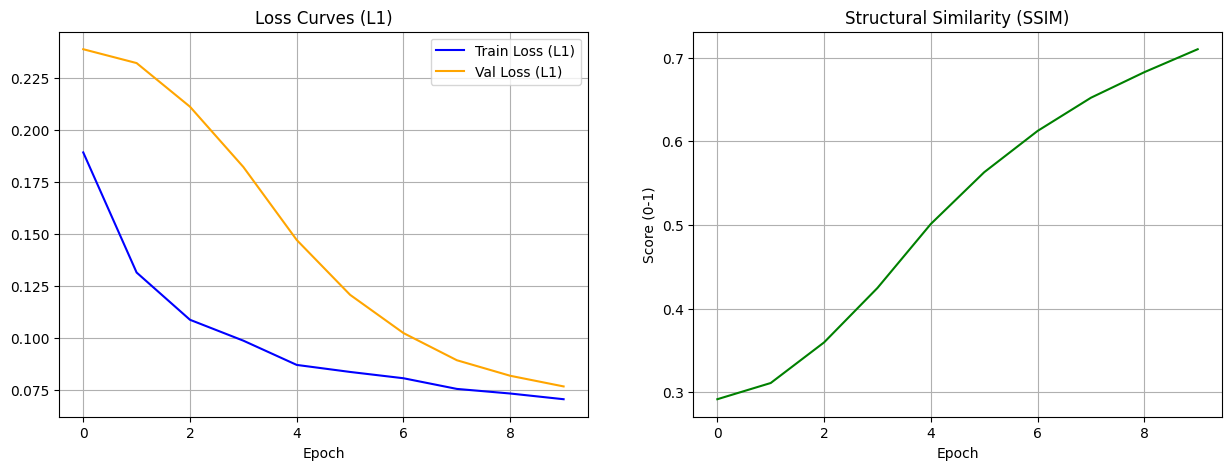

Metrics saved to outputs/images/project_metrics.png


In [40]:
# ==========================================
# Project: Old Pictures Colorization
# Based on: Projet Old Pictures Colorization.pdf
# Majid Bonyadi- Ayman Elourdi
# ==========================================

# 1. Install necessary libraries
# Note: Using torchmetrics as a robust alternative to torcheval for SSIM on Colab
!pip install torchmetrics kagglehub matplotlib

import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Import your local project files (Ensure unet.py and vintage_transforms.py are uploaded)
try:
    from unet import UNet
    from vintage_transforms import VintageTransform
except ImportError:
    print("Error: unet.py or vintage_transforms.py not found.")
    print("Please upload them to the Colab Files section.")

def train_project_compliant():
    # --- A. Dataset Preparation  ---
    print("Downloading Dataset (ImageNet-1K subset)...")
    dataset_path = kagglehub.dataset_download("kerrit/imagenet1kmediumtrain-100k")

    # Locate the training folder
    if "train" in os.listdir(dataset_path):
        data_root = os.path.join(dataset_path, "train")
    else:
        data_root = dataset_path
    print(f"Dataset root: {data_root}")

    # --- B. Configuration ---
    BATCH_SIZE = 16
    EPOCHS = 10
    LR = 1e-4

    # Requirement: Evaluate impact of class diversity.
    # Selecting specific classes as requested: 1st, 10th, 100th, 1000th
    # Note: ImageNet has 1000 classes. We select indices carefully.
    TARGET_INDICES = [1, 10, 100, 999] # Using 999 as the 1000th index (0-based)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Processing on: {device} ---")

    os.makedirs("outputs/models", exist_ok=True)
    os.makedirs("outputs/images", exist_ok=True)

    # --- C. Transforms & Custom Dataset Logic ---
    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Requirement: Automatic generation of "vintage photos"
    # This acts as the simulation of input data
    vintage_creator = VintageTransform(scratchProbability=0.5, noiseLevel=0.05)

    # Load Full Dataset
    try:
        full_dataset = datasets.ImageFolder(root=data_root, transform=base_transform)
    except Exception as e:
        print(f"Error reading dataset: {e}")
        return

    # Filter for Specific Classes
    print(f"Filtering dataset for class indices: {TARGET_INDICES}...")
    indices_to_keep = []
    found_classes = set()
    for idx, (_, label_idx) in enumerate(full_dataset.samples):
        if label_idx in TARGET_INDICES:
            indices_to_keep.append(idx)
            found_classes.add(label_idx)

    if not indices_to_keep:
        print("Warning: No images found. Checking first 100 images for test...")
        indices_to_keep = list(range(100))

    filtered_dataset = Subset(full_dataset, indices_to_keep)
    total_samples = len(filtered_dataset)
    print(f"Total samples after filtering: {total_samples}")

    # --- D. Train/Val Split [cite: 19, 20, 23, 24] ---
    # Requirement: Train set = 80%, Val set = 20%
    train_size = int(0.8 * total_samples)
    val_size = total_samples - train_size

    train_subset, val_subset = random_split(filtered_dataset, [train_size, val_size])

    print(f"Train Set Size (80%): {len(train_subset)}")
    print(f"Val Set Size (20%): {len(val_subset)}")

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # --- E. Model & Metrics [cite: 29, 30] ---
    # Requirement: U-Net architecture
    model = UNet().to(device)

    # Requirement: L1 Loss
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Requirement: SSIM Metric (Using torchmetrics as functional equivalent to torcheval)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    # --- F. Training Loop ---
    history = {'train_loss': [], 'val_loss': [], 'val_ssim': []}

    for epoch in range(EPOCHS):
        # 1. Training Phase
        model.train()
        train_loss_accum = 0.0

        for batch_i, (clean_imgs, _) in enumerate(train_loader):
            clean_imgs = clean_imgs.to(device)

            # Apply Vintage Transform "On-the-fly"
            # (Simulating greyscale, sepia, noise, etc.)
            noisy_imgs = torch.stack([vintage_creator(img.cpu()) for img in clean_imgs]).to(device)

            # Forward & Backward
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_accum += loss.item()

        avg_train_loss = train_loss_accum / len(train_loader)

        # 2. Validation Phase (Requirement: Monitor performance on Val set)
        model.eval()
        val_loss_accum = 0.0

        with torch.no_grad():
            for clean_imgs, _ in val_loader:
                clean_imgs = clean_imgs.to(device)
                noisy_imgs = torch.stack([vintage_creator(img.cpu()) for img in clean_imgs]).to(device)

                outputs = model(noisy_imgs)

                # Calculate Loss
                loss = criterion(outputs, clean_imgs)
                val_loss_accum += loss.item()

                # Calculate SSIM
                ssim_metric.update(outputs, clean_imgs)

        avg_val_loss = val_loss_accum / len(val_loader)
        avg_val_ssim = ssim_metric.compute().item()
        ssim_metric.reset()

        # Record History
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_ssim'].append(avg_val_ssim)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val SSIM: {avg_val_ssim:.4f}")

        # Save best model logic could be added here
        torch.save(model.state_dict(), "outputs/models/best_unet.pth")

    # --- G. Visualization ---
    print("Training Complete. Generating Report Graphs...")

    plt.figure(figsize=(15, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss (L1)', color='blue')
    plt.plot(history['val_loss'], label='Val Loss (L1)', color='orange')
    plt.title('Loss Curves (L1)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot SSIM
    plt.subplot(1, 2, 2)
    plt.plot(history['val_ssim'], label='Validation SSIM', color='green')
    plt.title('Structural Similarity (SSIM)')
    plt.xlabel('Epoch')
    plt.ylabel('Score (0-1)')
    plt.grid(True)

    plt.savefig("outputs/images/project_metrics.png")
    plt.show()
    print("Metrics saved to outputs/images/project_metrics.png")

if __name__ == "__main__":
    train_project_compliant()

Using Colab cache for faster access to the 'imagenet1kmediumtrain-100k' dataset.
Model loaded successfully.
Results image saved to outputs/images/final_results_visualization.png


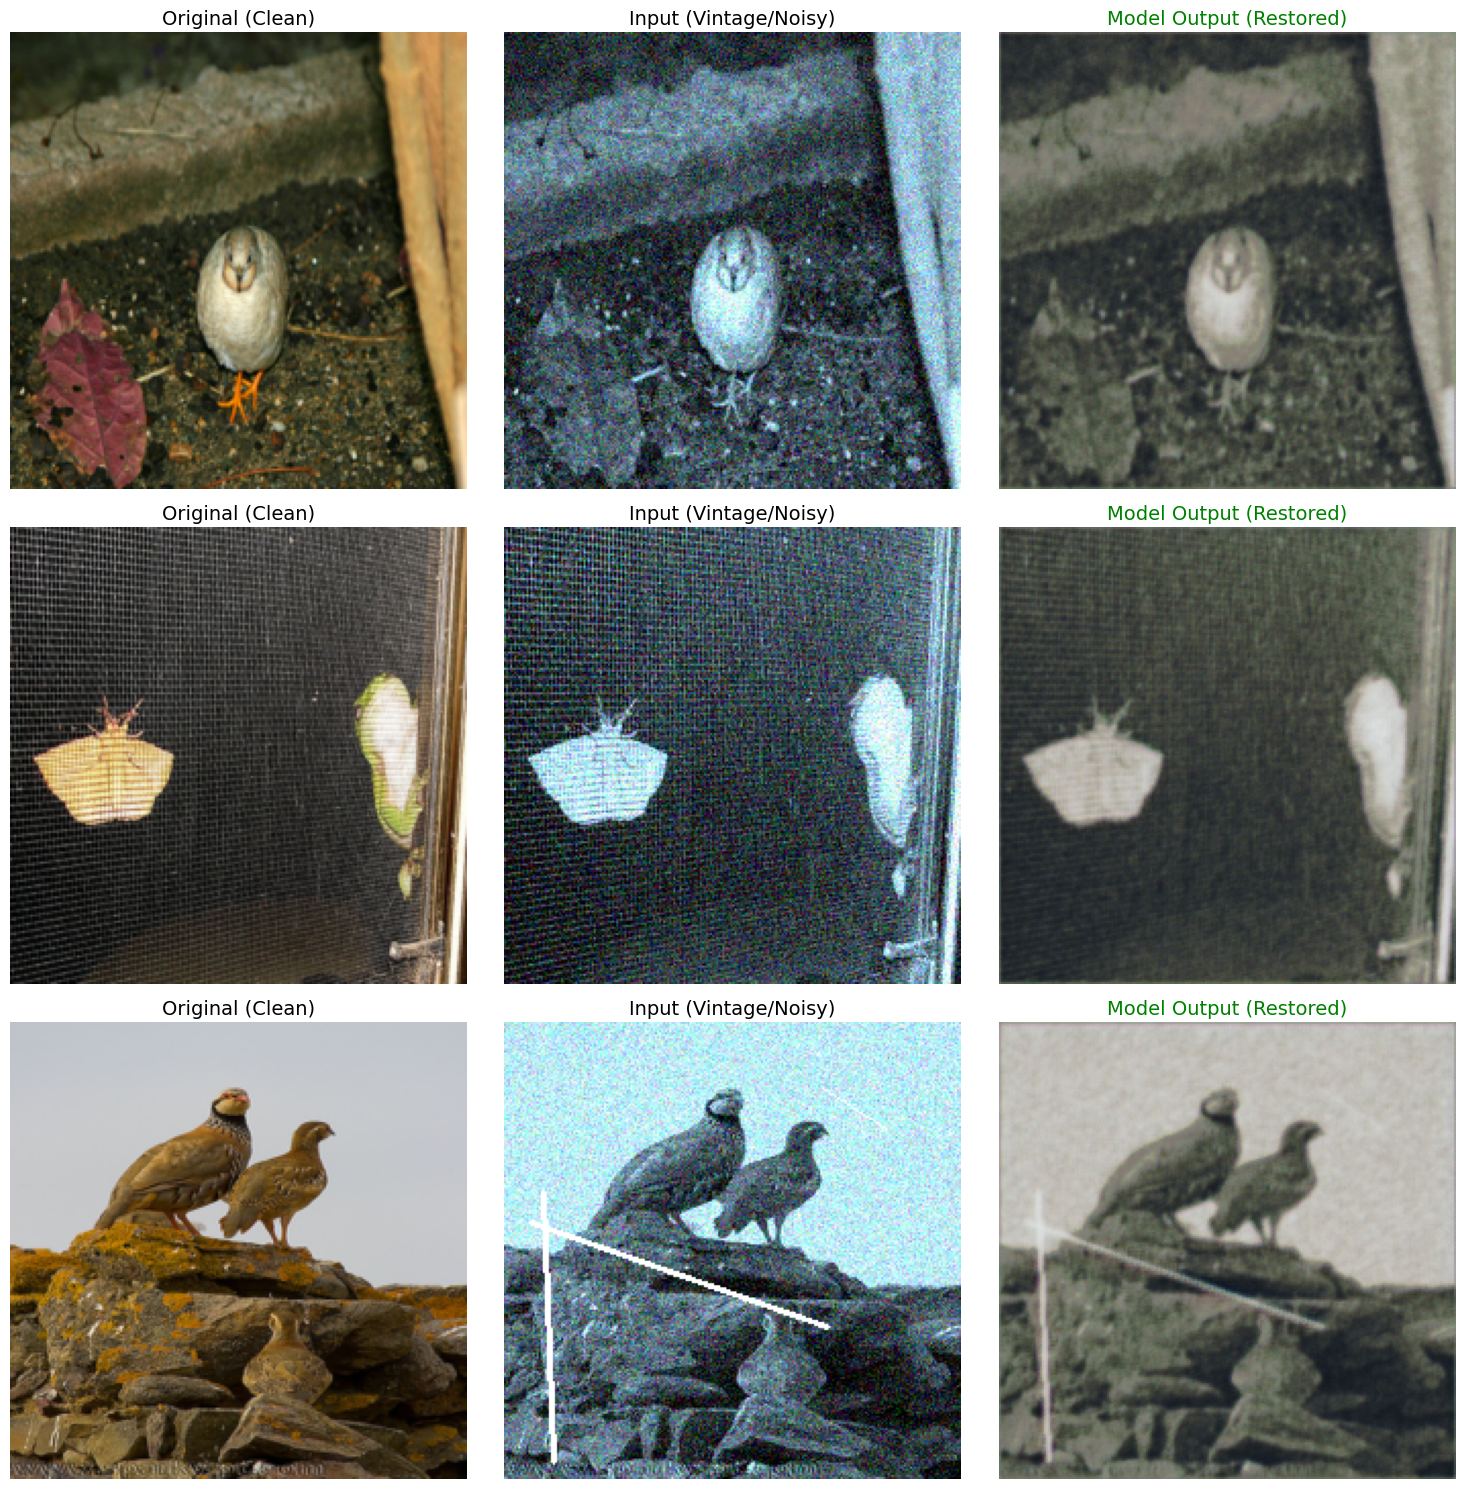

In [41]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
import os
from PIL import Image
from torchvision import transforms
import kagglehub

# Try importing project modules
try:
    from unet import UNet
    from vintage_transforms import VintageTransform
except ImportError:
    print("unet.py and vintage_transforms.py not found.")

def visualize_model_results(num_samples=12):
    """
    Loads the saved model and visualizes results on random test images.
    """
    # 1. Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "outputs/models/best_unet.pth"

    # Locate dataset path (using kagglehub cache)
    dataset_path = kagglehub.dataset_download("kerrit/imagenet1kmediumtrain-100k")
    if "train" in os.listdir(dataset_path):
        data_root = os.path.join(dataset_path, "train")
    else:
        data_root = dataset_path

    # 2. Load Model
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}! Please run the training script first.")
        return

    model = UNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Model loaded successfully.")

    # 3. Select Random Images
    # Walk through the directory to find .jpg files
    all_images = []
    for root, dirs, files in os.walk(data_root):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".JPEG"):
                all_images.append(os.path.join(root, file))
        # Limit search to avoid long wait times
        if len(all_images) > 500:
            break

    if not all_images:
        print("No images found for testing.")
        return

    selected_images = random.sample(all_images, num_samples)

    # 4. Image Processing Tools
    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    # Create vintage effect (slightly higher noise for visual demo)
    vintage_creator = VintageTransform(scratchProbability=0.6, noiseLevel=0.1)

    # 5. Display Results
    plt.figure(figsize=(15, 5 * num_samples))

    for i, img_path in enumerate(selected_images):
        # Open image
        img = Image.open(img_path).convert("RGB")

        # Create Ground Truth (Clean)
        clean_tensor = base_transform(img)

        # Create Input (Vintage)
        # VintageTransform runs on CPU/Numpy
        vintage_tensor = vintage_creator(clean_tensor)

        # Prepare for Model (Add Batch dimension & move to GPU)
        input_tensor = vintage_tensor.unsqueeze(0).to(device)

        # Model Inference
        with torch.no_grad():
            output_tensor = model(input_tensor)

        # Convert tensors to Numpy for Matplotlib (H, W, C)
        clean_display = clean_tensor.permute(1, 2, 0).numpy()
        vintage_display = vintage_tensor.permute(1, 2, 0).numpy()
        output_display = output_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

        # --- Plotting ---
        # Column 1: Original Clean
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(clean_display)
        plt.title("Original (Clean)", fontsize=14)
        plt.axis('off')

        # Column 2: Vintage Input
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(vintage_display)
        plt.title("Input (Vintage/Noisy)", fontsize=14)
        plt.axis('off')

        # Column 3: Model Output
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(output_display)
        plt.title("Model Output (Restored)", fontsize=14, color='green')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("outputs/images/final_results_visualization.png")
    print("Results image saved to outputs/images/final_results_visualization.png")
    plt.show()

# Run visualization
if __name__ == "__main__":
    visualize_model_results(num_samples=3)